In [1]:
# Importing libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP_action import GP_action
import time
import imageio
import pickle
import math
from turbo_1 import Turbo1
import time
import matplotlib


In [2]:
Noise=False# Specify if noisy or not
Noise_level= 0.05 # if noisy, what is the noise sd
'''If the scaled X and Y is being used rememeber to scale the noise as well'''

'If the scaled X and Y is being used rememeber to scale the noise as well'

In [3]:
# The target function is assigned, chose 1 from the below

objective=functions.Rosenbrock()
objective=functions.Synthetic()
objective=functions.sin()
objective=functions.sin_2(Noise,Noise_level)
objective=functions.sincos(Noise,Noise_level)
objective=functions.Branin()
objective=functions.Shubert(Noise,Noise_level)
objective=functions.Kean(Noise,Noise_level)
objective=functions.Shubert()
objective=functions.Kean(Noise,Noise_level)
objective=functions.Hartmann_3()
objective=functions.Hartmann_6()
objective=functions.Ackley_6()
objective=functions.Levy_10()
objective=functions.Rastrigin()
objective=functions.Ackley_6()


print(objective.bounds)
# Extracting the bounded range of the inputs
#func_bounds=bounds=np.array(
#            [item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])],dtype=np.float)
func_bounds=np.array(objective.bounds)
print(func_bounds)
#print(objective.func(np.array([0,0,0,0,0,0,0,0,0,0])))


[(-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10), (-5, 10)]
[[-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]
 [-5 10]]


In [4]:
class Levy:
    def __init__(self, dim=20):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]
        first = 1 + (coord[:,0]- 1.0) / 4.0
        last=1 + (coord[:,self.dim-1]- 1.0) / 4.0
        constant= np.sin(np.pi * first) ** 2
        sum_val=0
        for i in range(0,self.dim-1):
            w= 1 + (coord[:,i]- 1.0) / 4.0
            sum_val=sum_val+ (w - 1) ** 2 * (1 + 10 * np.sin(np.pi * w + 1) ** 2) + (last - 1) ** 2 * (1 + np.sin(2 * np.pi * w)**2)
        
        output=constant+sum_val
        return np.squeeze(output)

class Rastrigin:
    def __init__(self, dim=20):
        self.dim = dim
        self.lb = -3 * np.ones(dim)
        self.ub =  4 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]

        first = 10*self.dim
        sum_val=0
        for i in range(0,self.dim):
            sum_val=sum_val+(coord[:,i]**2 - 10 * np.cos(2*np.pi*coord[:,i]))
        output=first+sum_val
        return np.squeeze(1*output)
    
class Ackley:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub =  10 * np.ones(dim)
        
    def __call__(self, coord):
        if(coord.ndim==1):
            coord=coord[np.newaxis,:]
        firstSum = 0.0
        secondSum = 0.0
        for i in range(0,self.dim):
            c=coord[:,i]
            firstSum += c**2.0
            secondSum += np.cos(2.0*math.pi*c)
        n = float(self.dim)
        return np.squeeze(-20.0*np.exp(-0.2*np.sqrt(firstSum/n)) - np.exp(secondSum/n) + 20 + math.e)
       
    
f = Ackley(10)

In [5]:
# max budget for finding good point

# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES','GD']
acquation_function='gp_ucb'
function_bounds=func_bounds
func_name='Ackley'
Max= 0 # function max 3.86278, 3.32237
Max_eval=50
n_dim=10 # No of initial points
Budget=Max_eval+n_dim-1

In [6]:
turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=n_dim,  # Number of initial bounds from an Latin hypercube design
    max_evals = Budget,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=False,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


In [7]:

#acq=['GD','gp_ucb','EI','TS']
time_opt=np.array([]) 
acq=['Turbo','GD_Turbo'] # 'GD_Turbo'
Mean_dict = {} 
std_dict={}
k=0
mean=np.zeros(Max_eval)
std=np.zeros(Max_eval)
seed=np.random.randint(10000, size=5)
initial_X=np.array([])
while(k<2):
    temp_out=np.zeros(Max_eval)
    seed_count=0
    start_opt=time.time()
    for m in range(0,1):
        samples=[]
        acquation_function=acq[k]
        if(acquation_function=='Turbo'):
            turbo1 = Turbo1(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=n_dim,  # Number of initial bounds from an Latin hypercube design
    max_evals = Budget,  # Maximum number of evaluations
    batch_size=1,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=False,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)
            turbo1.optimize()
            X_temp=turbo1.X[0:n_dim]
            if(m==0):
                initial_X=X_temp
            else:
                initial_X=np.vstack((initial_X,X_temp))
            Y_value=np.array([])
            j=n_dim
            while(j<=Budget):
                Y_value=np.append(Y_value,np.min(np.squeeze(turbo1.fX[:j])))
                j=j+1
            samples=Y_value-Max
        else:
            seeds=seed[seed_count]
            Bo_test=GP_action(objective.func,function_bounds,Noise,Noise_level,acquation_function)
            X_start=initial_X[m*n_dim:(m+1)*n_dim]
            Bo_test.initiate(X_start,n_dim)
         #   Bo_test.initiate(seeds,n_random_draws=5)
            seed_count=seed_count+1
            flag = True
            i = 0
            samples.append(Max-np.max(Bo_test.Y))
            while flag:
                if i >= (Max_eval-1) :
                    break
                Bo_test.sample_new_value()
                Regret= Max-np.max(Bo_test.Y)
                samples.append(Regret)
                i += 1
        out=np.array(samples)
        temp_out=np.vstack((temp_out, out))
    finished_opt=time.time()
    time_opt=np.append(time_opt,finished_opt-start_opt)
    temp_out = np.delete(temp_out,(0), axis=0)
    mean_temp=np.mean(temp_out,axis=0)
    std_temp=0.5*np.sqrt(np.var(temp_out,axis=0)) # Calculating the one sided interval for 90% confidence

    mean=np.vstack((mean,mean_temp))
    std=np.vstack((std,std_temp))
    Mean_dict[acquation_function]=mean_temp
    std_dict[acquation_function]=std_temp
    k=k+1
    


Using dtype = torch.float64 
Using device = cpu
Starting from fbest = 11.24
13) New best: 11.21
14) New best: 10.99
17) New best: 8.315
27) New best: 6.435
41) New best: 4.82
47) New best: 4.725
58) New best: 4.723
0) Start Val: -11.24
5
1.5412524995343901
[ 2.17833985  3.84406424 -4.90405374 -2.4993326  -4.98504994 -0.12779942
  2.47475423  4.17095328  2.88864329 -3.18240716]
[[ 2.55301104  4.59127742 -5.         -2.49196939 -5.         -0.48092661
   1.89784112  4.78009027  2.47091659 -3.92213876]]
5
1.6128163499603927
[2.17833985 2.17833985 2.17833985 2.17833985 2.17833985 2.17833985
 2.17833985 2.17833985 2.17833985 2.17833985]
[[1.58804718 1.59814238 2.44979741 2.73216258 2.21927132 2.09410447
  2.87393765 2.25905053 3.05881706 2.68952632]]
2) Grad Step: -9.402
6
1.380757233155562
[1.58804718 1.59814238 2.44979741 2.73216258 2.21927132 2.09410447
 2.87393765 2.25905053 3.05881706 2.68952632]
[[2.18961183 2.13538689 2.481527   2.53730196 2.42152123 2.28668857
  1.91173144 1.8290268

3.9400549083971024
[7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537
 7.3455537 7.3455537 7.3455537]
[[7.72723478 6.83937917 8.05429857 6.82810401 5.78684445 7.89215806
  5.05964465 8.41028317 7.44160267 5.05307452]]
5
0.4288989887187583
[7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537
 7.3455537 7.3455537 7.3455537]
[[7.45704644 7.41450408 7.38837989 7.27133191 7.32628364 7.5426447
  7.58441101 7.37774551 7.41488375 7.10614899]]
5
4.432535573144863
[7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537
 7.3455537 7.3455537 7.3455537]
[[7.42230771 5.21045932 5.3836994  8.93527852 8.29228748 6.94761205
  6.11895876 8.14215567 4.99807327 7.29740266]]
5
3.6992212495503822
[7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537 7.3455537
 7.3455537 7.3455537 7.3455537]
[[9.01677751 8.59894012 7.92435368 7.24645199 8.62298585 6.07580309
  7.59530463 7.90273317 5.24914179 6.36393572]]
6
5.959420416891286
[7.3455537 7.3455537 7.3

In [ ]:
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
#save_obj(Mean_dict,func_name+'_Mean_'+'noisy_'+'Regret')
#save_obj(std_dict,func_name+'_Error_'+'noisy_'+'Regret')
save_obj(Mean_dict,func_name+'_Mean_'+'Regret')
save_obj(std_dict,func_name+'_Error_'+'Regret')



In [ ]:
plt.style.use('default')
import seaborn as sns
colors = sns.color_palette("dark")
greens = sns.color_palette("BuGn", 10)
blues = sns.color_palette("PuBu", 10)
reds = sns.color_palette("YlOrRd", 10)
purples = sns.color_palette("PuOr", 10)

def save_plot_T(mean,std):
    GD=np.arange(0,Max_eval,1)
    GP_UCB=np.arange(0,Max_eval,1)
    EI=np.arange(0,Max_eval,1)
    i=Max_eval
    size=30 # error every size
    
    # naming the x axis 
    fig,(ax1)=plt.subplots(figsize=(4.5, 3))
    plt.xlabel('Queries', fontsize=10) 
    # naming the y axis 
    plt.ylabel('Simple Regret',fontsize=10) 
    # giving a title to my graph 
    plt.title('')
    # show a legend on the plot 
    plt.legend() 
    ax1.plot(GD[:i], mean['GD'][:i],'-',color=reds[-1]) 
#    ax1.plot(GP_UCB[:i], mean['gp_ucb'][:i],'--',color=blues[-1]) 
 #   ax1.plot(EI[:i], mean['EI'][:i],'-.',color=purples[-1])
 #   ax1.plot(EI[:i], mean['TS'][:i],'-.',color=greens[-1])
 #   ax1.plot(GD[:i], mean['GD_5'][:i],'-',color=blues[-1]) 
    ax1.plot(GD[:i], mean['Turbo'][:i],'-',color=purples[-1]) 
    ax1.plot(GD[:i], mean['GD_Turbo'][:i],'-',color=greens[-1]) 
    
    ax1.errorbar(GD[:i],mean['GD'][:i],yerr=std['GD'][:i],label="Random_LS",linestyle='-',color=reds[-1],fmt='s',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(GP_UCB[:i],mean['gp_ucb'][:i],yerr=std['gp_ucb'][:i],label="gp_ucb",linestyle='--',color= blues[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(EI[:i],mean['EI'][:i],yerr=std['EI'][:i],label="EI",linestyle='-.',color=purples[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(EI[:i],mean['TS'][:i],yerr=std['TS'][:i],label="TS",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)
 #   ax1.errorbar(GD[:i],mean['GD_5'][:i],yerr=std['GD_5'][:i],label="GD_m",linestyle='--',color=blues[-1],fmt='>',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GD[:i],mean['Turbo'][:i],yerr=std['Turbo'][:i],label="Turbo",linestyle='-.',color=purples[-1],fmt='^',capsize=3,errorevery=size,markevery=size,lw=1.5)
    ax1.errorbar(GD[:i],mean['GD_Turbo'][:i],yerr=std['GD_Turbo'][:i],label="'GD_Turbo'",linestyle=':',color=greens[-1],fmt='x',capsize=3,errorevery=size,markevery=size,lw=1.5)




    ax1.legend(loc='upper right',fontsize=10)
    # function to show the plot
#    plt.fill_between(x, mean[1]-std[1], mean[1]+std[1],color='C0', alpha = 0.3)
#    plt.fill_between(x, mean[2]-std[2], mean[2]+std[2],color='C2', alpha = 0.3)
#    plt.fill_between(x, mean[3]-std[3], mean[3]+std[3],color='C4', alpha = 0.3)
    
    plt.show()
    fig.savefig('Ackley_noisless.pdf', bbox_inches='tight')

In [ ]:
#mean=load_obj(func_name+'_Mean_'+'noisy_'+'Regret')
#error=load_obj(func_name+'_Error_'+'noisy_'+'Regret')
mean=load_obj(func_name+'_Mean_'+'Regret')
error=load_obj(func_name+'_Error_'+'Regret')
save_plot_T(mean,error)


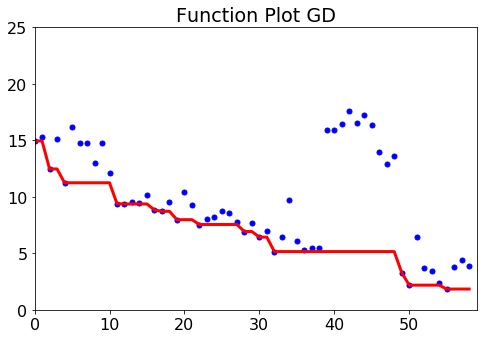

In [8]:
Bo_test.Y=Bo_test.Y*-1
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(Bo_test.Y, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(Bo_test.Y), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(Bo_test.Y)])
plt.ylim([0, 25])
plt.title("Function Plot GD")

plt.tight_layout()
plt.show()

In [ ]:
print(time_opt/5) #time for one run of Turbo,GD